# Анализ лояльности пользователей Яндекс Афиши

- Автор: Юлия Заботина
- Дата: 23.10.2025

### Цели и задачи проекта

**Цель:** Провести исследовательский анализ данных пользователей Яндекс Афиши с целью выявления пользователей, которые с большей вероятностью возвращаются на платформу и делают заказы повторно.   

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Создать профиль пользователя.
4. Провести исследовательский анализ данных.
5. Сформулировать выводы и рекомендации по проведённому анализу.
6. Опубликовать проект в Git.

### Описание данных

Схема `afisha` базы данных `data-analyst-afisha` содержит пять таблиц.

**Таблица** `purchases`

Содержит информацию о заказах билетов:
- `order_id` — идентификатор заказа;
- `user_id` — идентификатор пользователя, совершившего заказ;
- `created_dt_msk` — дата создания заказа по московскому времени;
- `created_ts_msk` — дата и время создания заказа по московскому времени;
- `event_id` — идентификатор мероприятия из таблицы `events`;
- `cinema_circuit` — сеть кинотеатров, где проходит мероприятие. Если оно проходит не в кинотеатре, то здесь будет значение нет;
- `age_limit` — возрастное ограничение мероприятия;
- `currency_code` — валюта оплаты;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (например, `mobile` — мобильные устройства, `desktop` — компьютеры);
- `revenue` — выручка от заказа;
- `service_name` — название билетного оператора;
- `tickets_count` — количество купленных билетов;
- `total` — общая сумма заказа.

**Таблица** `events`

Содержит данные о мероприятиях, доступных на платформе:
- `event_id` — идентификатор мероприятия;
- `event_name_code` — название мероприятия в закодированном виде;
- `event_type_description` — описание мероприятия;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `organizers` — организаторы мероприятия;
- `city_id` — идентификатор города проведения мероприятия из таблицы cities;
- `venue_id` — идентификатор площадки проведения мероприятия из таблицы venues.

**Таблица** `venues`

Содержит сведения о площадках проведения мероприятий:
- `venue_id` — идентификатор площадки;
- `venue_name` — название площадки;
- `address` — адрес площадки.

**Таблица** `city`

Содержит список городов, относящихся к регионам:
- `city_id` — идентификатор города;
- `city_name` — название города;
- `region_id` — идентификатор региона, в котором расположен город, из таблицы regions.

**Таблица** `regions`

Содержит список регионов, в которых проводятся мероприятия:
- `region_id` — идентификатор региона;
- `region_name` — название региона.

### Содержимое проекта

1. Загрузка данных и их предобработка.
2. Предобработка данных.
3. Создание профиля пользователя.
4. Исследовательский анализ данных.
5. Общий вывод и рекомендации.
6. Финализация проекта и публикация в Git.

## 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишем SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используем следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

---

In [1]:
# Для выгрузки используем библиотеку SQLAlchemy и модуль psycopg2
!pip install sqlalchemy
!pip install psycopg2-binary 

In [2]:
# Импортируем библиотеки для работы в проекте
import pandas as pd
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
!pip install phik
from phik import phik_matrix

In [3]:
# Запишем в объект db_config данные для подключения к базе данных data-analyst-afisha
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [4]:
# Сформируем с помощью метода .format() строку connection_string для подключения к базе данных data-analyst-afisha
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
# Передадим функции create_engine() строку connection_string с данными для подключения, чтобы создать соединение
engine = create_engine(connection_string)

In [6]:
# Запишем в переменную query SQL-запрос для составления датасета, который будем использовать в ходе анализа данных
query = '''
SELECT 
    user_id,
    device_type_canonical,
    order_id,
    created_dt_msk AS order_dt,
    created_ts_msk AS order_ts,
    currency_code,
    revenue,
    tickets_count,
    (created_dt_msk::date - LAG(created_dt_msk::date) OVER (PARTITION BY user_id ORDER BY created_dt_msk)) AS days_since_prev,
    event_id,
    event_name_code AS event_name,
    event_type_main,
    service_name,
    region_name,
    city_name
FROM afisha.purchases
JOIN afisha.events USING(event_id)
LEFT JOIN afisha.city USING(city_id)
LEFT JOIN afisha.regions USING(region_id)
WHERE device_type_canonical IN ('mobile', 'desktop') AND event_type_main != 'фильм'
ORDER BY user_id, created_dt_msk
'''

In [7]:
# Запишем в датафрейм с помощью метода pd.read_sql_query() результат выдачи SQL-запроса
df = pd.read_sql_query(query, con=engine)

In [8]:
# Выведем первые и последние строки полученного датафрейма df
display(df)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Широковская область,Ягодиновка


В выгрузке из базы данных SQL собраны следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---

**Задача 1.2:** Изучим общую информацию о выгруженных данных. Оценим корректность выгрузки и объём полученных данных.

---

In [9]:
# Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Датасет `df` сдержит 15 столбцов и 290611 строк, в которых представлена информация о покупках пользователей Яндекс Афиши.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов корректные, приведены к стилю snake case.
- Типы данных соответствуют содержимому. Тип данных столбца `tickets_count` можно оптимизировать с понижением размерности до int8.
- Пропуски содержит только столбец `days_since_prev`, что говорит о корректной выгрузке данных - ничего не потерялось. Пропуски в этом столбце означают, что пользователь совершил не более одного заказа, и не являются случайными.
- Значения в столбцах соответствуют описанию.

Первичное знакомство с данными показывает, что данные соответствуют описанию и выглядят корректными, пропуски датасета не требуют обработки.

---

###  2. Предобработка данных


---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведем выручку к единой валюте — российскому рублю.

Для этого используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраним в новый столбец `revenue_rub`.

---


In [10]:
# Загружаем датасет с информацией о курсе тенге по отношению к рублю за 2024 год
tenge_rate = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [11]:
# Выводим первые строки датасета
tenge_rate.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [12]:
# Переименовываем столбец data в order_dt для последующего объединения датасетов
tenge_rate = tenge_rate.rename(columns={'data': 'order_dt'})

In [13]:
# Приводим формат даты в датасете tenge_rate к datetime64
tenge_rate['order_dt'] = pd.to_datetime(tenge_rate['order_dt'], format='%Y-%m-%d')

In [14]:
# Объединяем датафреймы df и tenge_rate по дате
merged_df = df.merge(tenge_rate, on='order_dt', how='left')

In [15]:
# Создаем новый столбец revenue_rub и заполняем его значениями из столбца revenue
merged_df['revenue_rub'] = merged_df['revenue']

In [16]:
# Заменяем значения в тенге в столбце revenue_rub на рубли, рассчитанные по курсу на текущий день
merged_df.loc[merged_df['currency_code'] == 'kzt', 'revenue_rub'] = (merged_df['revenue'] * merged_df['curs'] / merged_df['nominal'])

In [17]:
# Выводим первые строки объединенного датасета для проверки корректности вычислений
merged_df[merged_df['currency_code'] == 'kzt'][['revenue', 'currency_code', 'curs', 'revenue_rub']].head()

,revenue,currency_code,curs,revenue_rub
70,518.10,kzt,19.0125,98.503762
89,347.18,kzt,18.9330,65.731589
96,328.77,kzt,18.5991,61.148261
277,22021.55,kzt,19.8928,4380.702898
460,7397.66,kzt,19.9833,1478.296591


In [18]:
# Убедимся, что расчеты не повлияли на значения выручки в рублях
merged_df[merged_df['currency_code'] == 'rub'][['revenue', 'currency_code', 'curs', 'revenue_rub']].head()

,revenue,currency_code,curs,revenue_rub
0,1521.94,rub,18.6972,1521.94
1,289.45,rub,18.3419,289.45
2,1258.57,rub,19.6475,1258.57
3,8.49,rub,18.5010,8.49
4,1390.41,rub,19.6648,1390.41


---

**Задача 2.2:**

- Проверим данные объединенного датасета на пропущенные значения. При первичном знакомстве с данными мы выяснили, что пропуски содержит только столбец `days_since_prev`, что говорит о корректной выгрузке данных. Подсчитаем долю строк с этими пропусками и проверим другие добавленные столбцы.
- Преобразуем тип данных столбца `tickets_count` с понижением размерности до int8.
- Изучим значения в ключевых столбцах и обработаем ошибки.

---

In [19]:
# Подсчитаем долю строк с пропусками
(merged_df.isna().sum() / merged_df.shape[0] * 100).sort_values(ascending=False)

days_since_prev          7.547202
user_id                  0.000000
event_name               0.000000
cdx                      0.000000
curs                     0.000000
nominal                  0.000000
city_name                0.000000
region_name              0.000000
service_name             0.000000
event_type_main          0.000000
event_id                 0.000000
device_type_canonical    0.000000
tickets_count            0.000000
revenue                  0.000000
currency_code            0.000000
order_ts                 0.000000
order_dt                 0.000000
order_id                 0.000000
revenue_rub              0.000000
dtype: float64

Доля пропущенных значений в столбце `days_since_prev` не превышает 8 %. Пропуски в этом столбце означают, что пользователь совершил не более одного заказа, и не являются случайными. В других столбцах пропусков не обнаружено.

In [20]:
# Оптимизируем целочисленный тип данных в столбце tickets_count
merged_df['tickets_count'] = pd.to_numeric(merged_df['tickets_count'], downcast='integer')

In [21]:
# Проверяем типы данных в датафрейме merged_df с помощью атрибута dtypes
merged_df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                      int8
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
nominal                           int64
curs                            float64
cdx                              object
revenue_rub                     float64
dtype: object

Тип данных столбца `tickets_count` приведен к int8.

In [22]:
# Проверяем уникальные значения в категориальных столбцах
for column in ['device_type_canonical', 'currency_code', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name']:
    print(f'Уникальные значения в столбце {column}:')
    print(merged_df[column].sort_values().unique())
    print()

Уникальные значения в столбце device_type_canonical:
['desktop' 'mobile']

Уникальные значения в столбце currency_code:
['kzt' 'rub']

Уникальные значения в столбце event_name:
['000a9c8d-65bb-4178-a5a8-9ddc1f3bf71e'
 '0015b11d-a3e0-4656-887a-383450a9b313'
 '00298e1a-ae90-482b-819d-ba88ceff59b0' ...
 'fff20f2b-de72-451a-8168-b765352e502c'
 'fff68929-41eb-4dd7-90bf-76d3ae8b652f'
 'fffd87ef-5469-4684-af21-4f9b86a13189']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']

Уникальные значения в столбце service_name:
['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Р

В категориальных столбцах категории с обозначением пропусков в данных или отсутствия информации не обнаружены. Нормализация данных не требуется.

In [23]:
# Получим краткое статистическое описание данных о выручке
merged_df['revenue_rub'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
95%        1630.650000
99%        2628.421739
max       81174.540000
Name: revenue_rub, dtype: float64

Среднее значение (556) значительно больше медианы (351), что может быть связано с выбросами в данных, которые увеличивают среднее значение. Значение стандартного отклонения также высокое - 875 при среднем значении 351, данные могут иметь широкий разброс. Максимальное значение (81174.54) похоже на аномальное.

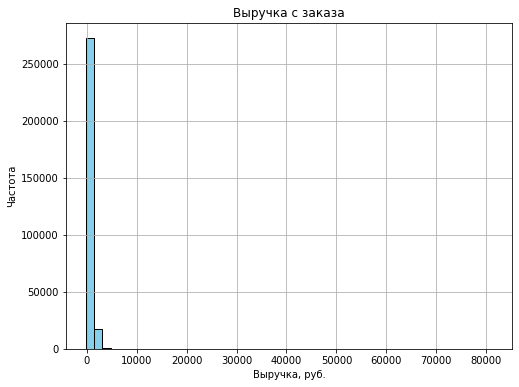

In [24]:
# Строим гистограмму распределения выручки
merged_df['revenue_rub'].plot(kind='hist', 
                   title='Выручка с заказа', 
                   legend=False, 
                   bins=50,                  
                   rot=0,
                   color='skyblue',
                   edgecolor='black',
                   figsize=(8, 6))
plt.xlabel('Выручка, руб.')
plt.ylabel('Частота')
plt.grid(axis='both')
plt.show()

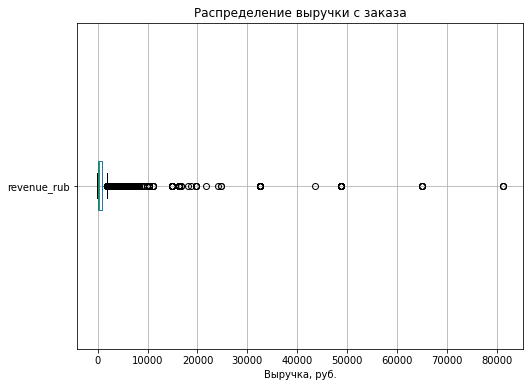

In [25]:
# Строим диаграмму размаха значений
merged_df.boxplot(column='revenue_rub', vert=False, figsize=(8, 6))

plt.title('Распределение выручки с заказа')
plt.xlabel('Выручка, руб.')
plt.show()

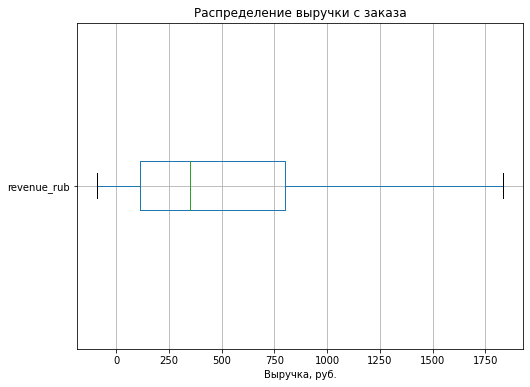

In [26]:
# Строим диаграмму размаха значений без выбросов
merged_df.boxplot(column='revenue_rub', vert=False, showfliers=False, figsize=(8, 6))

plt.title('Распределение выручки с заказа')
plt.xlabel('Выручка, руб.')
plt.show()

Распределение выручки с заказа - правое асимметричное. По диаграмме размаха видно, что значения выше 1800 руб. можно считать выбросами. Аномальные значения могут принадлежать большим корпоративным заказам для сотрудников предприятий.

In [27]:
# Получим краткое статистическое описание данных о количестве билетов в заказе
merged_df['tickets_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64

Среднее значение (2.75) немного меньше медианы (3.00). Значение стандартного отклонения невысокое - 1.17, значит, разброс данных не широкий. Максимальное значение количества билетов в заказе (57) похоже на аномальное и может быть связано с аномальным максимальным значением выручки, что укрепляет гипотезу о большом корпоративном заказе.

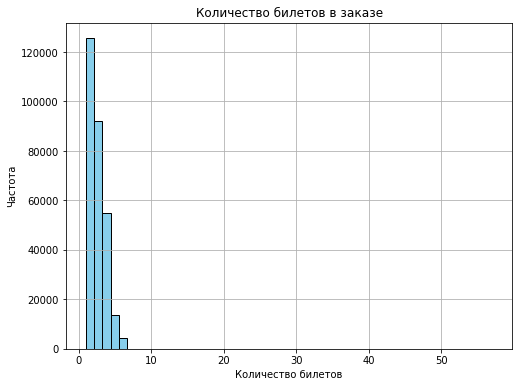

In [28]:
# Строим гистограмму распределения количества билетов в заказе
merged_df['tickets_count'].plot(kind='hist', 
                   title='Количество билетов в заказе', 
                   legend=False, 
                   bins=50,                  
                   rot=0,
                   color='skyblue',
                   edgecolor='black',
                   figsize=(8, 6))
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.grid(axis='both')
plt.show()

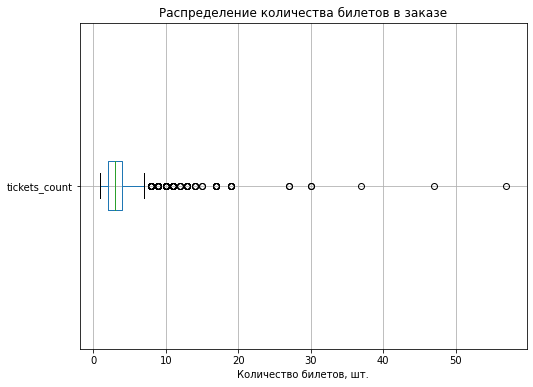

In [29]:
# Строим диаграмму размаха значений
merged_df.boxplot(column='tickets_count', vert=False, figsize=(8, 6))

plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов, шт.')
plt.show()

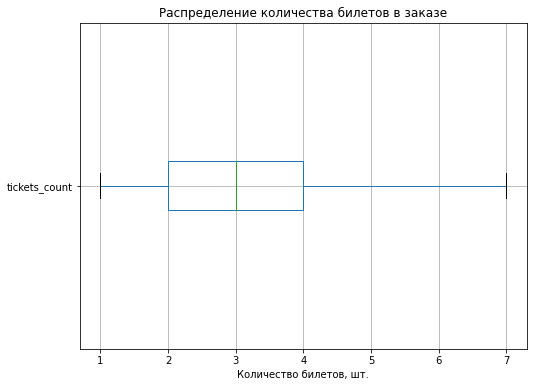

In [30]:
# Строим диаграмму размаха значений без выбросов
merged_df.boxplot(column='tickets_count', vert=False, showfliers=False, figsize=(8, 6))

plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов, шт.')
plt.show()

Распределение количества билетов в заказе - правое асимметричное. По диаграмме размаха видно, что значения выше 7 шт. можно считать выбросами. Аномальные значения могут принадлежать большим корпоративным заказам для сотрудников предприятий.

In [31]:
# Определяем 99-й перцентиль для выручки и количества заказов
revenue_p99 = merged_df['revenue_rub'].quantile(0.99)
tickets_p99 = merged_df['tickets_count'].quantile(0.99)
print("99-й перцентиль выручки:", round(revenue_p99, 2))
print("99-й перцентиль количества билетов:", round(tickets_p99))

99-й перцентиль выручки: 2628.42
99-й перцентиль количества билетов: 6


In [32]:
# Отфильтровываем значения больше 99-го перцентиля
filtered_df = merged_df[(merged_df['revenue_rub'] <= revenue_p99) & 
                        (merged_df['tickets_count'] <= tickets_p99)]

In [33]:
# Выводим количество отфильтрованных строк
removed = len(merged_df) - len(filtered_df)
print(f"Отфильтровано выбросов: {removed} строк ({removed / len(merged_df):.3%})")

Отфильтровано выбросов: 3005 строк (1.034%)


### В результате предобработки данных были выполнены следующие действия:

- Значения выручки сервиса приведены к единой валюте - российскому рублю. Результаты сохранены в новый столбец `revenue_rub`.
- Подсчитана доля пропусков в каждом столбце. Пропуски содержит только столбец `days_since_prev`, что говорит о корректной выгрузке данных. Доля пропущенных значений в столбце `days_since_prev` не превышает 8 %. Пропуски в этом столбце означают, что пользователь совершил не более одного заказа, и не являются случайными.
- Тип данных столбца `tickets_count` преобразован с понижением размерности до int8.
- Изучены значения в ключевых столбцах:
    - В категориальных столбцах категории с обозначением пропусков в данных или отсутствия информации не обнаружены. Нормализация данных не требуется.
    - В столбцах `revenue_rub` и `tickets_count` с численными данными обнаружены выбросы - аномальные максимальные значения, которые могут быть связаны с большими корпоративными заказами. Данные отфильтрованы - исключены выбросы по 99-му перцентилю. Количество отфильтрованных выбросов составило: 3005 строк (менее 2 %).

---

### 3. Создание профиля пользователя

Для создания модели для прогнозирования возврата пользователей построим агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Построим профиль пользователя — для каждого пользователя найдем:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используем поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавим два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.


---


In [34]:
# Сортируем данные по времени совершения заказа
filtered_df = filtered_df.sort_values('order_ts')

In [35]:
# Находим для каждого пользователя дату первого и последнего заказа
user_profile = filtered_df.groupby('user_id').agg(first_order_dt=('order_dt', 'min'), 
                                         last_order_dt=('order_dt', 'max')).reset_index()

In [36]:
# Находим для каждого пользователя первый заказ
first_orders = filtered_df.sort_values('order_ts').groupby('user_id').first().reset_index()

In [37]:
# Находим для каждого пользователя устройство, регион, билетного партнера и жанр мероприятия первого заказа
user_profile = user_profile.merge(first_orders[['user_id', 
                                                'device_type_canonical', 
                                                'region_name', 
                                                'service_name', 
                                                'event_type_main']], on='user_id', how='left')

# Переименовываем столбцы найденных параметров, чтобы не путать с исходными данными
user_profile.rename(columns={'device_type_canonical': 'first_device', 
                             'region_name': 'first_region', 
                             'service_name': 'first_service', 
                             'event_type_main': 'first_event_type'}, inplace=True)

In [38]:
# Находим остальные показатели
user_metrics = filtered_df.groupby('user_id').agg(orders_count=('order_id', 'nunique'), # общее количество заказов
                                                  avg_revenue=('revenue_rub', 'mean'), # средняя выручка с одного заказа в рублях
                                                  avg_tickets=('tickets_count', 'mean'), # среднее количество билетов в заказе
                                                  avg_days_since_prev=('days_since_prev', 'mean')).reset_index() # среднее время между заказами

# Соединяем найденные метрики в профиль пользователя
user_profile = user_profile.merge(user_metrics, on='user_id', how='left')

In [39]:
# Создаем бинарные признаки
user_profile['is_two'] = (user_profile['orders_count'] >= 2).astype(int) # пользователь совершил 2 и более заказа
user_profile['is_five'] = (user_profile['orders_count'] >= 5).astype(int) # пользователь совершил 5 и более заказов

# Оптимизируем целочисленный тип данных в полученных столбцах
user_profile['is_two'] = pd.to_numeric(user_profile['is_two'], downcast='integer')
user_profile['is_five'] = pd.to_numeric(user_profile['is_five'], downcast='integer')

In [40]:
# Выведем первые строки полученного профиля пользователя
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,orders_count,avg_revenue,avg_tickets,avg_days_since_prev,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


---

**Задача 3.2.** Перед проведением исследовательского анализа данных определим, с какими данными мы работаем: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитаем:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучим статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

---

In [41]:
# Определяем общее число пользователей в выборке
total_users = user_profile['user_id'].nunique()
print(f"Общее число пользователей в выборке: {total_users}")

Общее число пользователей в выборке: 21847


In [42]:
# Определяем среднюю выручку с одного заказа
total_avg_revenue = user_profile['avg_revenue'].mean()
print(f"Средняя выручка с одного заказа: {total_avg_revenue:.2f} руб.")

Средняя выручка с одного заказа: 544.16 руб.


In [43]:
# Определяем долю пользователей, совершивших 2 и более заказа
share_is_two = user_profile['is_two'].mean()
print(f"Доля пользователей, совершивших 2 и более заказа: {share_is_two:.2%}")

Доля пользователей, совершивших 2 и более заказа: 61.70%


In [44]:
# Определяем долю пользователей, совершивших 5 и более заказов
share_is_five = user_profile['is_five'].mean()
print(f"Доля пользователей, совершивших 5 и более заказов: {share_is_five:.2%}")

Доля пользователей, совершивших 5 и более заказов: 29.01%


In [45]:
# Выводим статистические показатели
stat_indicators = user_profile[['orders_count', # по общему числу заказов
                                'avg_tickets', # по среднему числу билетов в заказе
                                'avg_days_since_prev']].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]) # по среднему количеству дней между покупками 
print(stat_indicators)

       orders_count   avg_tickets  avg_days_since_prev
count  21847.000000  21847.000000         13509.000000
mean      13.164553      2.739164            15.837199
std      121.581813      0.902689            22.289646
min        1.000000      1.000000             0.000000
25%        1.000000      2.000000             1.000000
50%        2.000000      2.750000             8.000000
75%        5.000000      3.071429            20.333333
95%       31.000000      4.000000            61.500000
99%      151.540000      5.000000           112.000000
max    10168.000000      6.000000           148.000000


Статистические показатели по общему числу заказов `orders_count`:
- Среднее значение (13) значительно больше медианы (2), что может быть связано с выбросами в данных, которые увеличивают среднее значение. Значение стандартного отклонения также высокое - 122 при среднем значении 13, данные могут иметь широкий разброс. Максимальное значение (10168) похоже на аномальное.

Статистические показатели среднему числу билетов в заказе `avg_tickets`:
- Среднее значение (2.74) немного меньше медианы (3.07). Значение стандартного отклонения невысокое - 0.90, значит, разброс данных не широкий. Аномальных значений количества билетов нет, так как данные уже были отфильтрованы ранее.

Статистические показатели по среднему количеству дней между покупками `avg_days_since_prev`:
- Среднее значение (16) значительно больше медианы (8), что может быть связано с выбросами в данных, которые увеличивают среднее значение. Значение стандартного отклонения также высокое - 22 при среднем значении 8, данные могут иметь широкий разброс. Максимальное значение (148) похоже на аномальное.

In [46]:
# Определяем 99-й перцентиль для общего числа заказов и среднего количества дней между покупками
orders_p99 = user_profile['orders_count'].quantile(0.99)
days_p99 = user_profile['avg_days_since_prev'].quantile(0.99)

print(f"99-й перцентиль количества заказов: {round(orders_p99)}")
print(f"99-й перцентиль среднего количества дней между покупками: {round(days_p99)}")

# Вычисляем, сколько пользователей имеют аномальные значения для общего числа заказов или среднего количества дней между покупками
users_p99 = user_profile[(user_profile['orders_count'] > orders_p99) | 
                         (user_profile['avg_days_since_prev'] > days_p99)]
print(f"Аномальных пользователей: {len(users_p99)} ({len(users_p99) / len(user_profile):.2%})")

99-й перцентиль количества заказов: 152
99-й перцентиль среднего количества дней между покупками: 112
Аномальных пользователей: 353 (1.62%)


Количество пользователей, имеющих аномальные значения для общего числа заказов или среднего количества дней между покупками по 99-му перцентилю, составляет менее 2 % от общего числа. Допустимо отфильтровать эти аномальные значения, чтобы исключить искажение данных.

In [47]:
# Отфильтровываем значения больше 99-го перцентиля
filtered_profile = user_profile[(user_profile['orders_count'] <= orders_p99) & 
                                (user_profile['avg_days_since_prev'].isna() | 
                                (user_profile['avg_days_since_prev'] <= days_p99))]

# Выводим количество отфильтрованных строк
removed = len(user_profile) - len(filtered_profile)
print(f"Отфильтровано выбросов: {removed} пользователей ({removed / len(user_profile):.2%})")

Отфильтровано выбросов: 353 пользователей (1.62%)


In [48]:
# Выводим статистические показатели по обновленному датасету
print(filtered_profile[['orders_count', 'avg_tickets', 'avg_days_since_prev']].describe())

       orders_count   avg_tickets  avg_days_since_prev
count  21494.000000  21494.000000         13156.000000
mean       6.508095      2.739137            14.961588
std       14.258258      0.907362            19.465453
min        1.000000      1.000000             0.000000
25%        1.000000      2.000000             1.264396
50%        2.000000      2.750000             8.125000
75%        5.000000      3.090909            20.000000
max      151.000000      6.000000           112.000000


Анализ данных профиля пользователя показал:
- Общее число пользователей в выборке: 21847.
- Средняя выручка с одного заказа: 544.16 руб.
- Доля пользователей, совершивших 2 и более заказа: 62 %.
- Доля пользователей, совершивших 5 и более заказов: 29 %.
- Статистические показатели по общему числу заказов и среднему количеству дней между покупками показали содержание в данных аномальных значений. Количество пользователей, имеющих аномальные значения для этих параметров по 99-му перцентилю, составляет менее 2 % от общего числа (353 пользователя). Аномальные значения отфильтрованы. 
- Общее число пользователей в выборке после фильтрации: 21494.

Данные репрезентативны и готовы к проведению исследовательского анализа.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используем профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуем признаки, описывающие первый заказ пользователя, и выясним, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучим распределение пользователей по признакам.

- Сгруппируем пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитаем общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака.

---


In [49]:
# Группируем пользователей по типу их первого мероприятия
group_event_type = (filtered_profile.groupby('first_event_type').agg(users_count=('user_id', 'nunique')).reset_index())

# Считаем общее количество пользователей в каждом типе первого мероприятия
total_users = filtered_profile['user_id'].nunique()

# Считаем долю пользователей в каждом типе первого мероприятия
group_event_type['share_users'] = (group_event_type['users_count'] / total_users).round(2)

# Выводим результаты группировки пользователей по типу их первого мероприятия
print(group_event_type.sort_values('share_users', ascending=False))

  first_event_type  users_count  share_users
2         концерты         9492         0.44
1           другое         5389         0.25
5            театр         4209         0.20
4          стендап         1106         0.05
3            спорт          794         0.04
0         выставки          409         0.02
6             ёлки           95         0.00


Наибольшее количество пользователей совершили первый заказ на концерт (9492 пользователя, 44 %).

In [50]:
# Группируем пользователей по типу устройства, с которого совершена первая покупка
group_device_type = (filtered_profile.groupby('first_device').agg(users_count=('user_id', 'nunique')).reset_index())

# Считаем общее количество пользователей в каждом типе устройства, с которого совершена первая покупка
total_users = filtered_profile['user_id'].nunique()

# Считаем долю пользователей в каждом типе устройства, с которого совершена первая покупка
group_device_type['share_users'] = (group_device_type['users_count'] / total_users).round(2)

# Выводим результаты группировки пользователей по типу устройства, с которого совершена первая покупка
print(group_device_type.sort_values('share_users', ascending=False))

  first_device  users_count  share_users
1       mobile        17817         0.83
0      desktop         3677         0.17


Наибольшее количество пользователей совершили первый заказ с помощью мобильного устройства (17817 пользователей, 83 %).

In [51]:
# Группируем пользователей по региону проведения мероприятия из первого заказа
group_region = (filtered_profile.groupby('first_region').agg(users_count=('user_id', 'nunique')).reset_index())

# Считаем общее количество пользователей в каждом регионе проведения мероприятия из первого заказа
total_users = filtered_profile['user_id'].nunique()

# Считаем долю пользователей в каждом регионе проведения мероприятия из первого заказа
group_region['share_users'] = (group_region['users_count'] / total_users).round(2)

# Выводим результаты группировки пользователей по региону проведения мероприятия из первого заказа
print(group_region.sort_values('share_users', ascending=False))

            first_region  users_count  share_users
23    Каменевский регион         7029         0.33
60  Североярская область         3733         0.17
77   Широковская область         1219         0.06
45      Озернинский край          673         0.03
74      Травяная область          486         0.02
..                   ...          ...          ...
38       Луговая область           37         0.00
1     Берестовский округ           22         0.00
43  Миропольская область           83         0.00
44     Нежинская область           31         0.00
80    Яснопольский округ            1         0.00

[81 rows x 3 columns]


Наибольшее количество пользователей совершили первый заказ в Каменевском регионе (7029 пользователей, 33 %).

In [52]:
# Группируем пользователей по билетному оператору, продавшему билеты на первый заказ
group_service = (filtered_profile.groupby('first_service').agg(users_count=('user_id', 'nunique')).reset_index())

# Считаем общее количество пользователей, совершивших покупку в каждом билетном операторе, продавшем билеты на первый заказ
total_users = filtered_profile['user_id'].nunique()

# Считаем долю пользователей, совершивших покупку в каждом билетном операторе, продавшем билеты на первый заказ
group_service['share_users'] = (group_service['users_count'] / total_users).round(2)

# Выводим результаты группировки пользователей по билетному оператору, продавшему билеты на первый заказ
print(group_service.sort_values('share_users', ascending=False))

             first_service  users_count  share_users
3       Билеты без проблем         5144         0.24
22               Мой билет         2954         0.14
19             Лови билет!         2787         0.13
4            Билеты в руки         2544         0.12
23                 Облачко         2162         0.10
7           Весь в билетах         1274         0.06
20           Лучшие билеты         1179         0.05
24               Прачечная          580         0.03
17            Край билетов          452         0.02
12            Дом культуры          356         0.02
1              Show_ticket          157         0.01
28             Тебе билет!          307         0.01
21                Мир касс          205         0.01
33                  Яблоко          315         0.01
5              Быстробилет          162         0.01
13             За билетом!          200         0.01
11  Городской дом культуры          214         0.01
25            Радио ticket           36       

Наибольшее количество пользователей совершили первый заказ у оператора "Билеты без проблем" (5144 пользователя, 24 %).

Анализ распределения пользователей по сегментам показал, что распределение неравномерное - существует несколько ярко выраженных "точек входа":
- основной тип первого мероприятия - **концерты**;
- основное устройство для совершения первого заказа - **мобильное**;
- региональная концентрация первых заказов - **Каменевский регион**;
- лидер среди билетных операторов при совершении первого заказа - **"Билеты без проблем"**.

При планировании акций, рекомендаций и расширении охвата следует учитывать эти "точки входа", они могут быть связаны с массовостью и регулярностью проведения мероприятий, удобства использования мобильных устройств при совершении заказа, плотностью населения отдельных регионов и маркетинговой стратегией оператора-лидера.

---

**Задача 4.1.2.** Проанализируем возвраты пользователей:

- Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа.
- Визуализируем результат графиком с наибольшим количеством пользователей. 

---


  first_event_type  users_count  share_return_users
0         выставки          409                0.64
5            театр         4209                0.63
2         концерты         9492                0.62
4          стендап         1106                0.61
1           другое         5389                0.59
3            спорт          794                0.56
6             ёлки           95                0.56


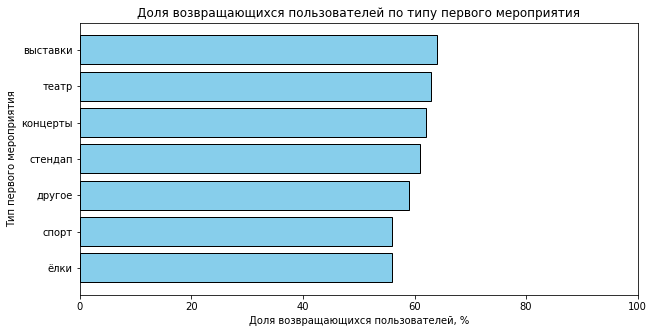

In [53]:
# Группируем пользователей, совершивших два и более заказа, по типу их первого мероприятия и считаем их долю
group_event_type = (filtered_profile.groupby('first_event_type').agg(users_count=('user_id', 'nunique'), 
                                                                     share_return_users=('is_two', 'mean')).reset_index())

# Сортируем для наглядности
group_event_type = group_event_type.sort_values('share_return_users', ascending=False)

# Округляем значения до двух знаков после запятой
group_event_type['share_return_users'] = group_event_type['share_return_users'].round(2)

# Выводим результаты группировки
print(group_event_type)

# Строим диаграмму распределения доли возвращающихся пользователей
plt.figure(figsize=(10, 5))
plt.barh(group_event_type['first_event_type'], group_event_type['share_return_users'] * 100, color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()
plt.title('Доля возвращающихся пользователей по типу первого мероприятия')
plt.xlabel('Доля возвращающихся пользователей, %')
plt.ylabel('Тип первого мероприятия')
plt.xlim(0, 100)
plt.show()

Распределение доли возвращающихся пользователей по типу первого мероприятия равномерное. Наибольшее количество возвращающихся пользователей в типах: выставки (64 %), театр (63 %), концерты (62 %).

  first_device  users_count  share_return_users
0      desktop         3677                0.64
1       mobile        17817                0.61


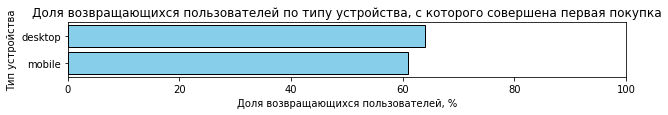

In [54]:
# Группируем пользователей, совершивших два и более заказа, по типу устройства, с которого совершена первая покупка, и считаем их долю
group_device_type = (filtered_profile.groupby('first_device').agg(users_count=('user_id', 'nunique'), 
                                                                  share_return_users=('is_two', 'mean')).reset_index())

# Сортируем для наглядности
group_device_type = group_device_type.sort_values('share_return_users', ascending=False)

# Округляем значения до двух знаков после запятой
group_device_type['share_return_users'] = group_device_type['share_return_users'].round(2)

# Выводим результаты группировки
print(group_device_type)

# Строим диаграмму распределения доли возвращающихся пользователей
plt.figure(figsize=(10, 1))
plt.barh(group_device_type['first_device'], group_device_type['share_return_users'] * 100, color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()
plt.title('Доля возвращающихся пользователей по типу устройства, с которого совершена первая покупка')
plt.xlabel('Доля возвращающихся пользователей, %')
plt.ylabel('Тип устройства')
plt.xlim(0, 100)
plt.show()

Распределение доли возвращающихся пользователей по типу устройства, с которого совершена первая покупка, равномерное. Количество возвращающихся пользователей для стационарных устройств (64 %) немного больше, чем для мобильных (61 %).

            first_region  users_count  share_return_users
76      Шанырский регион          495                0.67
57  Светополянский округ          453                0.65
77   Широковская область         1219                0.64
52   Речиновская область          437                0.64
60  Североярская область         3733                0.64
23    Каменевский регион         7029                0.62
74      Травяная область          486                0.61
78   Яблоневская область          410                0.59
41  Малиновоярский округ          522                0.56
45      Озернинский край          673                0.55


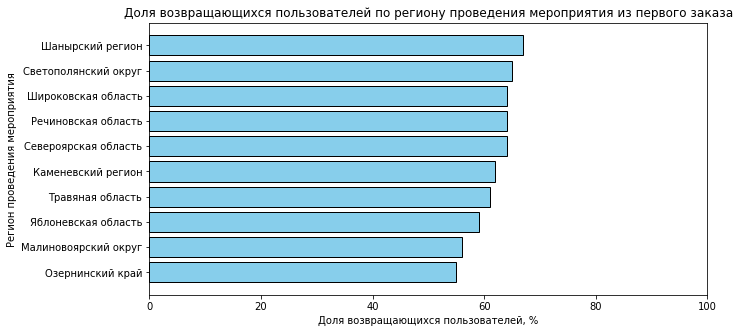

In [55]:
# Группируем пользователей, совершивших два и более заказа, по региону проведения мероприятия из первого заказа
group_region = (filtered_profile.groupby('first_region').agg(users_count=('user_id', 'nunique'), 
                                                             share_return_users=('is_two', 'mean')).reset_index())

# Отбираем топ-10 регионов по размеру сегмента, чтобы избежать нестабильных долей в маленьких группах
top10_regions = group_region.sort_values('users_count', ascending=False).head(10)

# Сортируем для наглядности
top10_regions = top10_regions.sort_values('share_return_users', ascending=False)

# Округляем значения до двух знаков после запятой
top10_regions['share_return_users'] = top10_regions['share_return_users'].round(2)

# Выводим результаты группировки
print(top10_regions)

# Строим диаграмму распределения доли возвращающихся пользователей
plt.figure(figsize=(10, 5))
plt.barh(top10_regions['first_region'], top10_regions['share_return_users'] * 100, color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()
plt.title('Доля возвращающихся пользователей по региону проведения мероприятия из первого заказа')
plt.xlabel('Доля возвращающихся пользователей, %')
plt.ylabel('Регион проведения мероприятия')
plt.xlim(0, 100)
plt.show()

Распределение доли возвращающихся пользователей по региону проведения мероприятия из первого заказа равномерное. Наибольшее количество возвращающихся пользователей в Шанырском регионе (67 %) и Светополянском округе (65 %).

         first_service  users_count  share_return_users
17        Край билетов          452                0.65
12        Дом культуры          356                0.65
7       Весь в билетах         1274                0.63
4        Билеты в руки         2544                0.63
24           Прачечная          580                0.62
20       Лучшие билеты         1179                0.61
23             Облачко         2162                0.61
22           Мой билет         2954                0.61
19         Лови билет!         2787                0.61
3   Билеты без проблем         5144                0.60


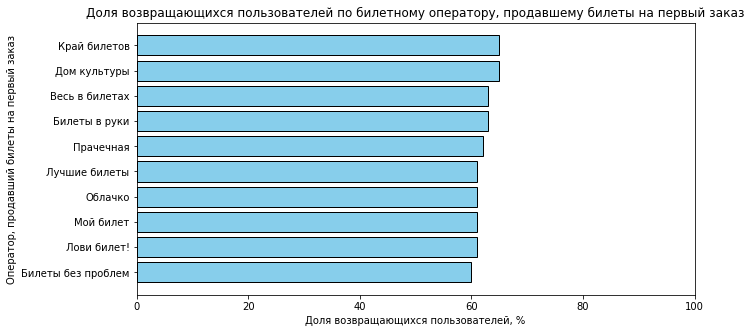

In [56]:
# Группируем пользователей, совершивших два и более заказа, по билетному оператору, продавшему билеты на первый заказ
group_service = (filtered_profile.groupby('first_service').agg(users_count=('user_id', 'nunique'), 
                                                               share_return_users=('is_two', 'mean')).reset_index())

# Отбираем топ-10 билетных операторов по размеру сегмента, чтобы избежать нестабильных долей в маленьких группах
top10_services = group_service.sort_values('users_count', ascending=False).head(10)

# Сортируем для наглядности
top10_services = top10_services.sort_values('share_return_users', ascending=False)

# Округляем значения до двух знаков после запятой
top10_services['share_return_users'] = top10_services['share_return_users'].round(2)

# Выводим результаты группировки
print(top10_services)

# Строим диаграмму распределения доли возвращающихся пользователей
plt.figure(figsize=(10, 5))
plt.barh(top10_services['first_service'], top10_services['share_return_users'] * 100, color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()
plt.title('Доля возвращающихся пользователей по билетному оператору, продавшему билеты на первый заказ')
plt.xlabel('Доля возвращающихся пользователей, %')
plt.ylabel('Оператор, продавший билеты на первый заказ')
plt.xlim(0, 100)
plt.show()

Распределение доли возвращающихся пользователей по билетному оператору, продавшему билеты на первый заказ, равномерное. Наибольшее количество возвращающихся пользователей купили билеты у операторов "Край билетов" (65 %) и "Дом культуры" (65 %).

Анализ распределения возвращающихся пользователей по сегментам показал, что распределение равномерное, ярко выраженных "точек входа" нет, однако чаще совершают повторный заказ при следующих условиях:
- основной тип первого мероприятия - **выставки, театр, концерты**;
- основное устройство для совершения первого заказа - **стационарное**;
- регион проведения мероприятий первых заказов - **Шанырский регион и Светополянский округ**. При этом регионы с низкой плотностью населения (с десятками пользователей) не учитывались для избежания статистической нестабильности долей;
- лидеры среди билетных операторов при совершении первого заказа - **"Край билетов" и "Дом культуры"**. При этом менее популярные операторы (с десятками пользователей) не учитывались для избежания статистической нестабильности долей.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверим продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [57]:
# Отбираем данные для типа первого мероприятия "спорт" и "концерты", чтобы сравнить долю возвращающихся пользователей
filtered_events = group_event_type[group_event_type['first_event_type'].isin(['спорт', 'концерты'])]

# Выводим результаты отфильтрованной группировки
print(filtered_events[['first_event_type', 'share_return_users']])

  first_event_type  share_return_users
2         концерты                0.62
3            спорт                0.56


**Гипотеза 1** не подтверждается: пользователи, впервые совершившие заказ на спортивные мероприятия, совершают повторный заказ реже (56 %), чем пользователи, оформившие свой первый заказ на концерты (62 %). 

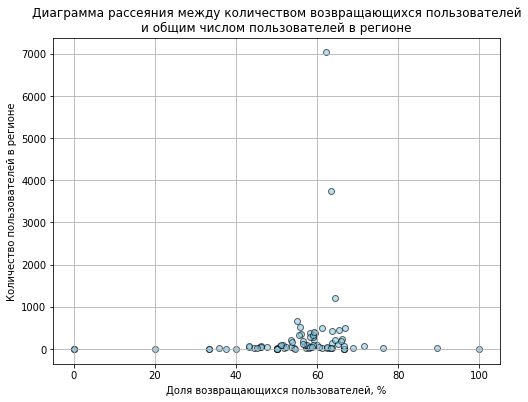

In [58]:
# Построим диаграмму рассеяния между долей возвращающихся пользователей 'share_return_users' и общим количеством пользователей 'users_count'
plt.figure(figsize=(8, 6))
plt.scatter(group_region['share_return_users'] * 100, 
            group_region['users_count'], 
            alpha=0.6, 
            color='skyblue', 
            edgecolors='black')
plt.xlabel('Доля возвращающихся пользователей, %')
plt.ylabel('Количество пользователей в регионе')
plt.title('Диаграмма рассеяния между количеством возвращающихся пользователей\nи общим числом пользователей в регионе')
plt.grid(axis='both')
plt.show()

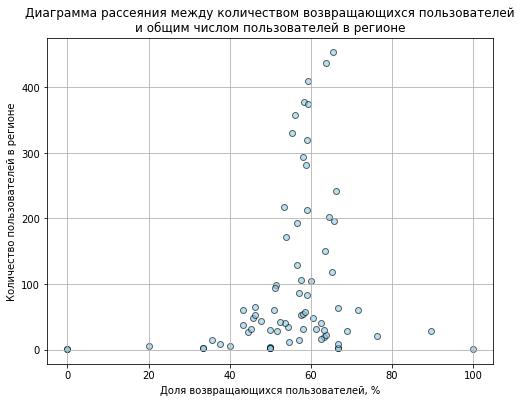

Корреляция между количеством возвращающихся пользователей и общим числом пользователей в регионе (без выбросов): 0.22


In [59]:
# Обрежем выбросы по столбцу 'users_count'
Q1 = group_region['users_count'].quantile(0.25)
Q3 = group_region['users_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_region = group_region[(group_region['users_count'] >= lower_bound) & (group_region['users_count'] <= upper_bound)]

# Перестроим диаграмму рассеяния
plt.figure(figsize=(8, 6))
plt.scatter(filtered_region['share_return_users'] * 100, 
            filtered_region['users_count'], 
            alpha=0.6, 
            color='skyblue', 
            edgecolors='black')
plt.xlabel('Доля возвращающихся пользователей, %')
plt.ylabel('Количество пользователей в регионе')
plt.title('Диаграмма рассеяния между количеством возвращающихся пользователей\nи общим числом пользователей в регионе')
plt.grid(axis='both')
plt.show()

# Вычислим корреляцию без выбросов по столбцу 'users_count'
corr = filtered_region['share_return_users'].corr(filtered_region['users_count'])
print(f'Корреляция между количеством возвращающихся пользователей и общим числом пользователей в регионе (без выбросов): {corr:.2f}')

**Гипотеза 2** не подтверждается. По диаграмме рассеяния видно, что тип связи между количеством возвращающихся пользователей и общим числом пользователей в регионе - нелинейный, однозначно установить направление и силу связи затруднительно. При первичном построении диаграммы рассеяния был обнаружен аномальный выброс общего количества пользователей в регионе, впоследствии диаграмма перестроена без выбросов по столбцу `users_count`, пересчитано значение корреляции и получено значение 0.22, что соответствует слабой корреляционной связи.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследим связь между средней выручкой сервиса с заказа и повторными заказами.

- Построим сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.


---


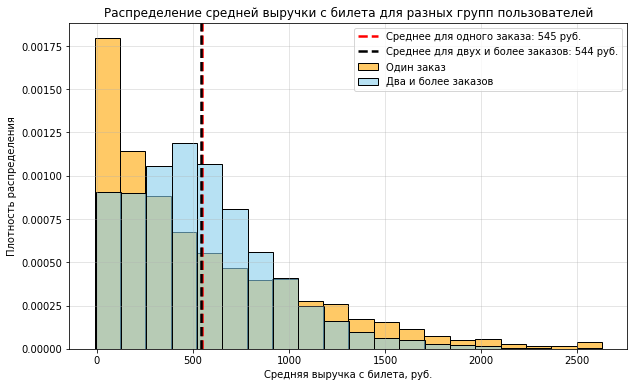

In [60]:
# Разделяем пользователей на две группы
one_order = filtered_profile.loc[filtered_profile['is_two'] == 0, 'avg_revenue'] # совершил один заказ
several_orders = filtered_profile.loc[filtered_profile['is_two'] == 1, 'avg_revenue'] # совершил несколько заказов

# Строим гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(one_order, color='orange', bins=20, label='Один заказ', kde=False, alpha=0.6, stat='density')
sns.histplot(several_orders, color='skyblue', bins=20, label='Два и более заказов', kde=False, alpha=0.6, stat='density')

# Добавляем вертикальные линии со средними значениями
plt.axvline(one_order.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Среднее для одного заказа: {one_order.mean():.0f} руб.')
plt.axvline(several_orders.mean(), color='black', linestyle='--', linewidth=2.5, label=f'Среднее для двух и более заказов: {several_orders.mean():.0f} руб.')

# Строим диаграмму распределения
plt.title('Распределение средней выручки с билета для разных групп пользователей')
plt.xlabel('Средняя выручка с билета, руб.')
plt.ylabel('Плотность распределения')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

Основная концентрация пользователей обеих групп (и с одним заказом, и с несколькими) находится в диапазоне до 750 рублей средней выручки с билета. Формы распределений двух групп схожи — оба правосторонние, с постепенным спадом при увеличении суммы средней выручки с билета. Для распределения группы пользователей с одним заказом наблюдается высокая плотность распределения в диапазоне от 0 до 125 рублей.

Среднее значение средней выручки с билета отличается незначительно: 
- у пользователей с одним заказом 545 руб.;
- у пользователей с несколькими заказами 544 руб.

Схожесть средних значений показывает, что зависимости между величиной средней выручки с билета и совершением повторных заказов нет.

---

**Задача 4.2.2.** Сравним распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

---


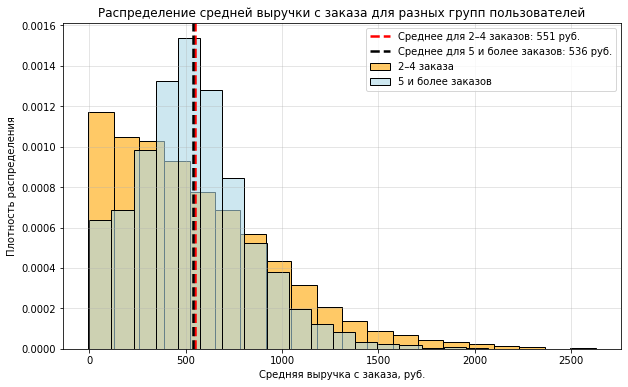

In [61]:
# Разделяем пользователей на две группы
group_2_4 = filtered_profile[(filtered_profile['orders_count'] >= 2) & 
                             (filtered_profile['orders_count'] < 5)] # совершил 2-4 заказа
group_5_plus = filtered_profile[filtered_profile['orders_count'] >= 5] # совершил 5 и более заказов

# Извлекаем среднюю выручку
revenue_2_4 = group_2_4['avg_revenue']
revenue_5_plus = group_5_plus['avg_revenue']

# Строим гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(revenue_2_4, color='orange', bins=20, label='2–4 заказа', kde=False, alpha=0.6, stat='density', edgecolor='black')
sns.histplot(revenue_5_plus, color='lightblue', bins=20, label='5 и более заказов', kde=False, alpha=0.6, stat='density', edgecolor='black')

# Добавляем средние линии
plt.axvline(revenue_2_4.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Среднее для 2–4 заказов: {revenue_2_4.mean():.0f} руб.')
plt.axvline(revenue_5_plus.mean(), color='black', linestyle='--', linewidth=2.5, label=f'Среднее для 5 и более заказов: {revenue_5_plus.mean():.0f} руб.')

# Оформляем график
plt.title('Распределение средней выручки с заказа для разных групп пользователей')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

Основная концентрация пользователей обеих групп находится в диапазоне до 900 рублей средней выручки с заказа. 

Форма распределения группы для 2-4 заказов - правосторонняя, с постепенным спадом при увеличении суммы средней выручки с заказа. 

Форма распределения группы для 5 и более заказов - также правосторонняя, но с ростом плотности распределения до среднего значения суммы средней выручки с заказа и последующим постепенным спадом.

Среднее значение средней выручки с заказа отличается незначительно: 
- у пользователей с 2-4 заказами 551 руб.;
- у пользователей с 5 и больше заказами 536 руб.

Схожесть средних значений показывает, что существенных различий по средней выручке с заказа между группами нет: частота заказов не связана напрямую с размером среднего чека.

---

**Задача 4.2.3.** Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучим распределение пользователей по среднему количеству билетов в заказе (`avg_tickets`) и опишем основные наблюдения.
- Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы.

---

     tickets_segment  users_count  share_return_users
0         1–2 билета         2406                0.51
1         2–3 билета         9451                0.73
2        3–5 билетов         8990                0.54
3  5 и более билетов          647                0.18


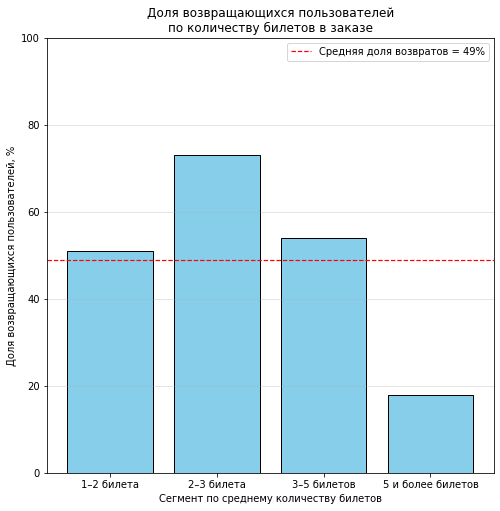

In [62]:
# Создаем сегменты по среднему количеству билетов в заказе
bins = [0, 2, 3, 5, float('inf')]
labels = ['1–2 билета', '2–3 билета', '3–5 билетов', '5 и более билетов']

tickets_segment_profile = filtered_profile[['user_id', 'avg_tickets', 'is_two']].copy()
tickets_segment_profile['tickets_segment'] = pd.cut(tickets_segment_profile['avg_tickets'], bins=bins, labels=labels, right=False)

# Группируем по сегментам и считаем долю пользователей, совершивших повторные заказы
segment_stats = (tickets_segment_profile.groupby('tickets_segment').agg(users_count=('user_id', 'nunique'), 
                                                                        share_return_users=('is_two', 'mean')).reset_index())

# Округляем долю возвращающихся пользователей до двух знаков
segment_stats['share_return_users'] = segment_stats['share_return_users'].round(2)

# Выводим результаты группировки
print(segment_stats)

# Строим диаграмму распределения по сегментам
plt.figure(figsize=(8, 8))
plt.bar(segment_stats['tickets_segment'], segment_stats['share_return_users'] * 100, color='skyblue', edgecolor='black')
plt.title('Доля возвращающихся пользователей\nпо количеству билетов в заказе')
plt.xlabel('Сегмент по среднему количеству билетов')
plt.ylabel('Доля возвращающихся пользователей, %')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.4)

# Создаем переменную для среднего значения доли возвращающихся пользователей
avg_share_return = (segment_stats['share_return_users'] * 100).mean()

# Строим линию для визуализации среднего значения доли возвращающихся пользователей
plt.axhline(avg_share_return, color='red', linestyle='--', linewidth=1.2, label=f'Средняя доля возвратов = {avg_share_return:.0f}%')
plt.legend()
plt.show()

Распределение доли возвращающихся пользователей по сегментам неравномерное. 

Наибольшая доля возвращающихся пользователей соответствует сегменту "2–3 билета" (73 %, что можно считать аномально высоким значением, по сравнению со средним значением в 49 %). 

Меньше всего возвращающихся пользователей в сегменте "5 и более билетов" (18 %, что можно считать аномально низким значением, по сравнению со средним значением в 49 %).

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучим временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируем, как день недели, в который была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделим день недели.
- Для каждого дня недели подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы. 

---


  first_order_weekday  users_count  share_return_users
1              Monday         2906                0.63
5             Tuesday         3157                0.62
6           Wednesday         3031                0.62
4            Thursday         3101                0.59
0              Friday         3239                0.60
2            Saturday         3303                0.63
3              Sunday         2757                0.60


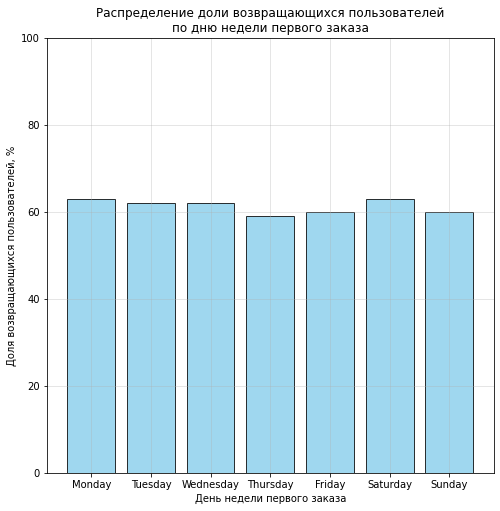

In [63]:
# Создаем столбец с днём недели
weekday_profile = filtered_profile[['user_id', 'first_order_dt', 'is_two']].copy()
weekday_profile['first_order_weekday'] = weekday_profile['first_order_dt'].dt.day_name()

# Группируем по дню недели и считаем долю пользователей, совершивших повторные заказы
weekday_stats = (weekday_profile.groupby('first_order_weekday').agg(users_count=('user_id', 'nunique'), 
                                                                    share_return_users=('is_two', 'mean')).reset_index())

# Округляем долю пользователей, совершивших повторные заказы, до двух знаков
weekday_stats['share_return_users'] = (weekday_stats['share_return_users']).round(2)

# Сортируем по дням недели
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['first_order_weekday'] = pd.Categorical(weekday_stats['first_order_weekday'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('first_order_weekday')

# Выводим результат
print(weekday_stats)

# Строим диаграмму распределения по дням недели первого заказа
plt.figure(figsize=(8, 8))
plt.bar(weekday_stats['first_order_weekday'], weekday_stats['share_return_users'] * 100, color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Распределение доли возвращающихся пользователей\nпо дню недели первого заказа')
plt.xlabel('День недели первого заказа')
plt.ylabel('Доля возвращающихся пользователей, %')
plt.ylim(0, 100)
plt.grid(alpha=0.4)
plt.show()

Распределение доли возвращающихся пользователей по дню недели первого заказа равномерное, можно сделать вывод о том, что день недели, в который совершена первая покупка, не влияет на вероятность возврата клиента.

---

**Задача 4.3.2.** Изучим, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитаем среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуем, как средний интервал между заказами влияет на вероятность повторного заказа.

---


         order_group  mean_interval
0         2–4 заказа           19.0
1  5 и более заказов           10.0


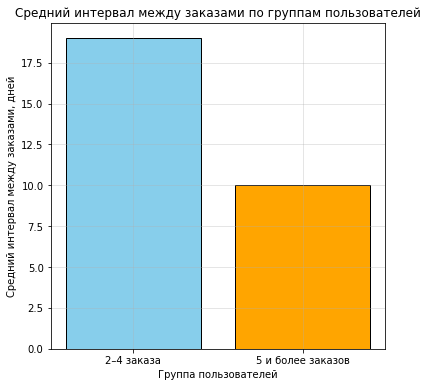

In [64]:
# Создаем сегменты для двух групп пользователей (2-4 заказа и 5 и более заказов)
interval_profile = filtered_profile[['user_id', 'orders_count', 'avg_days_since_prev']].copy()
interval_profile['order_group'] = pd.cut(interval_profile['orders_count'], bins=[1, 4, float('inf')], labels=['2–4 заказа', '5 и более заказов'], right=True)

# Рассчитываем средний интервал между заказами по группам
interval_stats = (interval_profile.groupby('order_group').agg(mean_interval=('avg_days_since_prev', 'mean')).reset_index())

# Округляем средний интервал между заказами
interval_stats['mean_interval'] = (interval_stats['mean_interval']).round()

# Выводим результат
print(interval_stats)

# Строим диаграмму распределения по среднему интервалу между заказами
plt.figure(figsize=(6, 6))
plt.bar(interval_stats['order_group'], interval_stats['mean_interval'], color=['skyblue', 'orange'], edgecolor='black')
plt.title('Средний интервал между заказами по группам пользователей')
plt.ylabel('Средний интервал между заказами, дней')
plt.xlabel('Группа пользователей')
plt.grid(alpha=0.4)
plt.show()

Пользователи, совершающие 5 и более заказов, делают покупки значительно чаще (средний интервал между заказами - 10 дней), чем пользователи, совершающие 2–4 заказа (средний интервал между заказами - 19 дней, почти вдвое больше).

Можно сделать вывод о том, что частота заказов напрямую связана с вероятностью повторной покупки.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используем универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведем корреляционный анализ:
- Рассчитаем коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`orders_count`). 
- Проанализируем полученные результаты.
- Визуализируем результат корреляции с помощью тепловой карты.

---

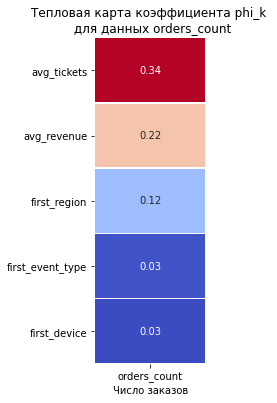

In [65]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = filtered_profile[['orders_count', 'avg_revenue', 'avg_tickets', 'first_device', 'first_region', 'first_event_type']].phik_matrix(interval_cols=['orders_count', 'avg_revenue', 'avg_tickets'])
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)

# Cтроим тепловую карту
plt.figure(figsize=(2, 6))
sns.heatmap(data=data_heatmap, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            linewidths=0.5,
            cbar=False)
plt.title('Тепловая карта коэффициента phi_k \n для данных orders_count')
plt.xlabel('Число заказов')
plt.show()

По тепловой карте коэффициента phi_k видно, что наибольшая связь между числом заказов и средним количеством билетов в заказе - 0.34, что соответствует умеренной положительной корреляционной связи. Это может быть связано с тем, что пользователи, которые в среднем покупают больше билетов за один заказ, чаще совершают повторные покупки.

Между числом заказов и средней выручкой слабая положительная корреляционная связь - 0.22. Возможно пользователи с более высокой средней выручкой в заказе имеют тенденцию быть более лояльными.

Между числом заказов и регионом, в котором совершен первый заказ, также слабая положительная корреляционная связь - 0.12. У остальных признаков связи практически нет (0.03).

### 5. Общий вывод и рекомендации


Исходный датасет df сдержит 15 столбцов и 290611 строк, в которых представлена информация о покупках пользователей Яндекс Афиши.
Для проведения исследовательского анализа данных было выполнено следующее:
- Данные о выручке сервиса приведены к единой валюте — российскому рублю.
- Выполнена проверка данных на пропущенные значения. Выявлено 8 % пропущенных значений в столбце `days_since_prev`, которые связаны с тем, что пользователь совершил не более одного заказа (не являются случайными).
- Тип данных столбца `tickets_count` преобразован с понижением размерности до int8.
- В столбцах `revenue_rub` и `tickets_count` с численными данными обнаружены выбросы - аномальные максимальные значения, которые могут быть связаны с большими корпоративными заказами. Данные отфильтрованы - исключены выбросы по 99-му перцентилю. Количество отфильтрованных выбросов составило: 3005 строк (менее 2 %).
- Построены агрегированные признаки, описывающие поведение и профиль каждого пользователя:
    - дата первого и последнего заказа;
    - устройство, с которого был сделан первый заказ;
    - регион, в котором был сделан первый заказ;
    - билетный партнёр, к которому обращались при первом заказе;
    - жанр первого посещённого мероприятия;
    - общее количество заказов;
    - средняя выручка с одного заказа в рублях;
    - среднее количество билетов в заказе;
    - среднее время между заказами.
- Добавлены два бинарных признака:
    - is_two — совершил ли пользователь 2 и более заказа;
    - is_five — совершил ли пользователь 5 и более заказов.
- Выполнена проверка репрезентативности данных. Анализ данных профиля пользователя показал:
    - общее число пользователей в выборке: 21847;
    - средняя выручка с одного заказа: 544.16 руб;
    - доля пользователей, совершивших 2 и более заказа: 62 %;
    - доля пользователей, совершивших 5 и более заказов: 29 %.
- Статистические показатели по общему числу заказов и среднему количеству дней между покупками показали содержание в данных аномальных значений. Количество пользователей, имеющих аномальные значения для этих параметров по 99-му перцентилю, составляет менее 2 % от общего числа (353 пользователя). Аномальные значения отфильтрованы. Общее число пользователей в выборке после фильтрации: 21494.

В ходе исследовательского анализа данных было выявлено:
- Анализ распределения пользователей по сегментам показал, что существует несколько ярко выраженных "точек входа" при совершении первого заказа:
    - основной тип первого мероприятия - концерты;
    - основное устройство для совершения первого заказа - мобильное;
    - региональная концентрация первых заказов - Каменевский регион;
    - лидер среди билетных операторов при совершении первого заказа - "Билеты без проблем".
При планировании акций, рекомендаций и расширении охвата следует учитывать эти "точки входа", они могут быть связаны с массовостью и регулярностью проведения мероприятий, удобства использования мобильных устройств при совершении заказа, плотностью населения отдельных регионов и маркетинговой стратегией оператора-лидера.

- Анализ распределения возвращающихся пользователей по сегментам показал, что ярко выраженных "точек входа" нет, однако чаще совершают повторный заказ при следующих условиях:
    - основной тип первого мероприятия - выставки, театр, концерты;
    - основное устройство для совершения первого заказа - стационарное;
    - регион проведения мероприятий первых заказов - Шанырский регион и Светополянский округ. При этом регионы с низкой плотностью населения (с десятками пользователей) не учитывались для избежания статистической нестабильности долей;
    - лидеры среди билетных операторов при совершении первого заказа - "Край билетов" и "Дом культуры". При этом менее популярные операторы (с десятками пользователей) не учитывались для избежания статистической нестабильности долей.

- Анализ взаимосвязи между средней выручкой сервиса с заказа и повторными заказами показал:
    - зависимости между величиной средней выручки с билета и совершением повторных заказов нет;
    - существенных различий по средней выручке с заказа между группами "2-4 заказа" и "5 и более заказов" также нет - частота заказов не связана напрямую с размером среднего чека.

- Анализ влияния среднего количества билетов в заказе на вероятность повторной покупки показал:
    - меньше всего возвращающихся пользователей в сегменте "5 и более билетов";
    - наибольшая доля возвращающихся пользователей соответствует сегменту "2–3 билета".

- Исследование временных характеристик первого заказа показало:
     - день недели, в который совершена первая покупка, не влияет на вероятность возврата клиента;
     - частота заказов напрямую связана с вероятностью повторной покупки (пользователи, совершающие 5 и более заказов, делают покупки значительно чаще, чем пользователи, совершающие не более 4 заказов).

- Корреляционный анализ количества покупок и признаков пользователя показал, что число заказов пользователей сильнее всего связано с характеристиками их покупательской активности (количество билетов в заказе и средней выручкой).

**Рекомендации:**

- Для стимулирования повторных заказов следует отправлять персональные предложения пользователям не позднее, чем через 10 дней после покупки (средний интервал повторной покупки пользователей сегмента "5 и более покупок"). Кроме того, следует обратить внимение на следующие "точки входа": театр и выставки, Шанырский и Светополянский регионы.
- Для привлечения новых пользователей при проведении рекламных кампаний следует обратить внимание на выявленные "точки входа": концерты, заказ через мобильное устройство, Каменевский регион, сервис "Билеты без проблем".
- Основной фокус следует направить на повышение частоты покупок, а не среднего чека.

### 6. Финализация проекта и публикация в Git
